In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/albert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Define train/validation/test Datasets & get the vocabulary:

In [4]:
import os.path
import pickle

from datasets.flickr8k import Flickr8kDataset
#from utils_torch import *


DATASET_BASE_PATH = 'data/flickr8k/'
VOCAB = 'vocab_set.pkl'

train_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train',
    device=device, return_type='tensor', load_img_to_memory=False)

vocab_set = tuple()

if os.path.exists(VOCAB):
    with open(VOCAB, 'rb') as f:
        vocab_set = pickle.load(f)
else:
    vocab_set = train_set.get_vocab()
    with open(VOCAB, 'wb') as f:
        pickle.dump(vocab_set, f)
    

vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)

val_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

test_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

train_eval_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)


print(
    f"The number of samples in:\ntrain: {len(train_set)};"
    + f" validation: {len(val_set)}; test: {len(test_set)}\n"
    + f"Vocabulary size: {vocab_size}; Max length of a sentence: {max_len};"
)

The number of samples in:
train: 30000; validation: 1000; test: 1000
Vocabulary size: 7708; Max length of a sentence: 40;


# Define Data Transformations & Dataloaders:

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader


BATCH_SIZE = 16


train_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.RandomCrop(224),  # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(224),  # get 224x224 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

train_set.transformations = train_transformations
val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations


eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, sampler=None, pin_memory=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

# Define the model, loss, metric, optimizer, embedding_matrix:

#### Note: you can use:
    - densenet161_gru
    - densenet161_lstm

#### Probably you can add the other models as well and use the notebook, but check!

In [6]:
from models.torch.densenet161_lstm import Captioner
MODEL = "densenet161_lstm"

In [9]:
from glove import embedding_matrix_creator
from metrics import bleu_score_fn, accuracy_fn 
from utils_torch import words_from_tensors_fn

EMBEDDING_DIM = 50
EMBEDDING = f"GLV{EMBEDDING_DIM}"
HIDDEN_SIZE = 256
LR = 1e-2


embedding_matrix = embedding_matrix_creator(embedding_dim=EMBEDDING_DIM, word2idx=word2idx)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

final_model = Captioner(EMBEDDING_DIM, HIDDEN_SIZE, vocab_size, num_layers=2,
                        embedding_matrix=embedding_matrix, train_embd=False).to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_set.pad_value).to(device)
acc_fn = accuracy_fn(ignore_value=train_set.pad_value)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)

params = (
    list(final_model.decoder.parameters())
    + list(final_model.encoder.embed.parameters())
    + list(final_model.encoder.bn.parameters())
)

optimizer = torch.optim.Adam(params=params, lr=LR)

100%|██████████| 7708/7708 [00:00<00:00, 700960.39it/s]


Embedding matrix shape: (7708, 50)


# Main training cycle:

**Note:** modify train_from_scratch=True if you want to get your model!

In [11]:
train_from_scratch = False

from utils_torch import check_create_dir, get_picture_caption
from train_torch import train_model, evaluate_model
from PIL import Image

if train_from_scratch:
    check_create_dir(f'saved_models/{MODEL}')
    MODEL_NAME = f'saved_models/{MODEL}/{MODEL}_b{BATCH_SIZE}_emd{EMBEDDING}'
    NUM_EPOCHS = 100
    print(MODEL_NAME)


    train_loss_min = 100
    val_bleu4_max = 0.0

    for epoch in range(NUM_EPOCHS):
        train_loss = train_model(
            desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}',
            model=final_model,                                                                      
            optimizer=optimizer,
            loss_fn=loss_fn,                                          
            train_loader=train_loader
        )

        with torch.no_grad():
            train_bleu = evaluate_model(
                desc=f'\tTrain Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=train_eval_loader
            )

            val_bleu = evaluate_model(
                desc=f'\tValidation Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=val_loader
            )

            print(f'Epoch {epoch + 1}/{NUM_EPOCHS}',
                ''.join([f'train_bleu{i}: {train_bleu[i]:.4f} ' for i in (1, 4)]),
                ''.join([f'val_bleu{i}: {val_bleu[i]:.4f} ' for i in (1, 4)]),
                )
            
            state = {
                'epoch': epoch + 1,
                'state_dict': final_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss_latest': train_loss,
                'val_bleu4_latest': val_bleu[4],
                'train_loss_min': min(train_loss, train_loss_min),
                'val_bleu4_max': max(val_bleu[4], val_bleu4_max),
                'train_bleus': train_bleu,
                'val_bleus': val_bleu,
            }

            torch.save(state, f'{MODEL_NAME}_latest.pt')

            if train_loss < train_loss_min:
                train_loss_min = train_loss
                torch.save(state, f'{MODEL_NAME}''_best_train.pt')
                
            if val_bleu[4] > val_bleu4_max:
                val_bleu4_max = val_bleu[4]
                torch.save(state, f'{MODEL_NAME}''_best_val.pt')

    torch.save(state, f'{MODEL_NAME}_ep{NUM_EPOCHS:02d}_weights.pt')

In [ ]:
PATH = f'{MODEL_NAME}_best_val.pt'
if train_from_scratch:
    final_model.eval()
else:
    final_model = Captioner(EMBEDDING_DIM, HIDDEN_SIZE, vocab_size, num_layers=2,
                            embedding_matrix=embedding_matrix, train_embd=False).to(device)
    final_model.load_state_dict(torch.load(PATH)['state_dict'])
    final_model.eval()

In [8]:
dset = train_eval_set
idx = 100
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

In [9]:
dset = val_set
idx = 500
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

In [10]:
dset = test_set
idx = 500
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

In [11]:
if train_from_scratch:
    inter_params = {
        'model': final_model,
        'loss_fn': loss_fn,
        'bleu_score_fn': corpus_bleu_score_fn,
        'tensor_to_word_fn': tensor_to_word_fn,
        'vocab_size': vocab_size,
    }

    with torch.no_grad():
        final_model.eval()
        train_bleu = evaluate_model(
            desc=f'Train: ',
            data_loader=train_eval_loader,
            **inter_params,
        )
        
        val_bleu = evaluate_model(
            desc=f'Val: ',
            data_loader=val_loader,
            **inter_params,
        )
        
        test_bleu = evaluate_model(
            desc=f'Test: ',
            data_loader=test_loader,
            **inter_params,
        )
        for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
            print(setname, end=' ')
            for ngram in (1, 2, 3, 4):
                print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
            print()

# Get best checkpoint results:

In [12]:
MODEL_DIR = './'
MODEL_NAME = 'densenet161_lstm_b16_emdGLV50_best_val.pt'

!gdown --id 1CLODHygvcd9Lfczy5bsUT656OkXOTvUG
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME))
!rm densenet161_lstm_b16_emdGLV50_best_val.pt

/home/albert/.local/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CLODHygvcd9Lfczy5bsUT656OkXOTvUG
To: /home/albert/skoltech_classes/term4/DL/Project/image_captioning/densenet161_lstm_b16_emdGLV50_best_val.pt
100%|████████████████████████████████████████| 144M/144M [00:02<00:00, 51.1MB/s]


In [13]:
final_model = Captioner(EMBEDDING_DIM, HIDDEN_SIZE, vocab_size, num_layers=2).to(device)
final_model.load_state_dict(checkpoint['state_dict'])
final_model.eval()

Captioner(
  (encoder): Encoder(
    (densenet): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
      

width=-1: a man in a red shirt is sitting on a bench . 
width=3: a man in a red shirt is sitting on a bench . 
width=5: a man in a red shirt is sitting on a bench . 
width=7: a man in a red shirt is sitting on a bench . 
GT: ['A girl in a petterned shirt is talking to a guy with a hat in a billiards room .', 'A man holding a pool stick talking to a woman in a pool hall', 'A man in a black hat is talking to a woman with an animal print shirt .', 'Boy holding pool cue looking at person in sweater', 'Two people are talking to each other at a pool place .']


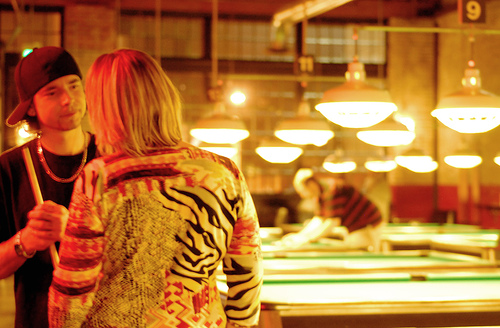

In [14]:
dset = train_eval_set
idx = 100
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

width=-1: a man in a red shirt is sitting on a bench . 
width=3: a man in a red shirt is sitting on a bench . 
width=5: a man in a red shirt is sitting on a bench . 
width=7: a man in a red shirt is sitting on a bench . 
GT: ['A crowd of people look at something out of frame , one man takes a picture .', 'A group of people stop to look at something while one takes a picture .', 'A woman with a shopping bag labeled " sale " stands in a crowd next to a young man with a camera .', 'The man is taking a picture while the crowd gathers .', 'The woman in glasses is holding a red and white sale bag .']


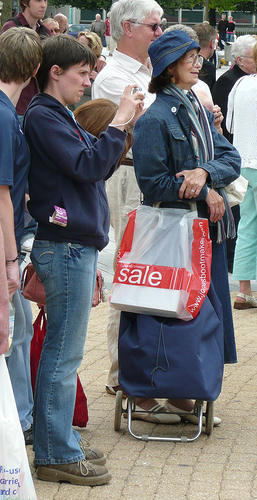

In [15]:
dset = val_set
idx = 500
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

width=-1: a man in a red shirt is playing with a ball . 
width=3: a man in a red shirt is playing with a ball . 
width=5: a man in a red shirt is playing with a ball . 
width=7: a man in a red shirt is playing with a ball . 
GT: ['A man is lying on the grass next to a shopping cart .', 'A person is lying on the green grass and there is a small cart next to them .', 'A person lies on the grass with a shopping cart nearby .', 'There is a shopping cart and a person laying on the ground in a green field of grass .', 'There is one person lying in a large , green field .']


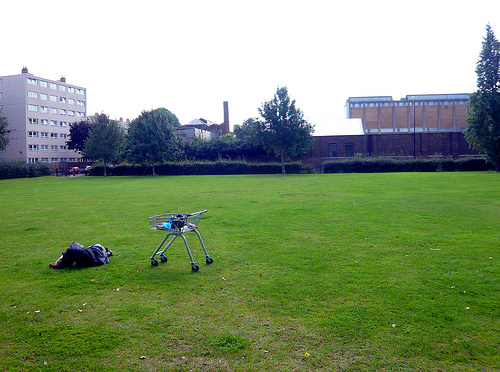

In [16]:
dset = test_set
idx = 500
width_range = [-1, 3, 5, 7]
for i in width_range:
    generated_caption = get_picture_caption(idx, dset, final_model, idx2word, beam_width=-1)
    print(f"width={i}: {generated_caption}")
print(f"GT: {dset.get_image_captions(idx)[1]}")
Image.open(dset.get_image_captions(idx)[0])

In [19]:
inter_params = {
    'model': final_model,
    'bleu_score_fn': corpus_bleu_score_fn,
    'tensor_to_word_fn': tensor_to_word_fn,
}

with torch.no_grad():
    final_model.eval()
    train_bleu = evaluate_model(
        desc=f'Train: ',
        data_loader=train_eval_loader,
        **inter_params,
    )
    
    val_bleu = evaluate_model(
        desc=f'Val: ',
        data_loader=val_loader,
        **inter_params,
    )
    
    test_bleu = evaluate_model(
        desc=f'Test: ',
        data_loader=test_loader,
        **inter_params,
    )
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
        print()

Test: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s, bleu1=0.555, bleu4=0.103]

train Bleu-1: 0.55340237874761 Bleu-2: 0.3139624982355366 Bleu-3: 0.1798643399777471 Bleu-4: 0.10986197591768854 
val Bleu-1: 0.5540899574811622 Bleu-2: 0.31532005940433744 Bleu-3: 0.1799437499421383 Bleu-4: 0.10918716772442374 
test Bleu-1: 0.5553237553668845 Bleu-2: 0.30958288848741045 Bleu-3: 0.1719193805216551 Bleu-4: 0.10272423557405617 
